<a href="https://colab.research.google.com/github/yoo9519-AIdev/Learning/blob/master/InceptionResNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InceptionResNetV2
- ChestX CNN 모델과 같은 데이터셋  
(2020.11.09.) 수정

### 필요모듈호출 및 GPU 확인

In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  1
2.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 경로지정 및 size 조정

In [4]:
DATA_DIR = '/content/drive/My Drive/분당서울대병원_AI_project/kaggle_chest_xray'
# DATA_DIR2 = '../input/chest-xray-pneumonia/'
image_size = 224
batch_size = 32

### 데이터 구조 확인 및 조정

In [ ]:
df = pd.read_csv(f'/content/drive/My Drive/분당서울대병원_AI_project/kaggle_chest_xray/Data_Entry_2017.csv')
data_image_paths = {os.path.basename(x): x for x in tqdm(glob(os.path.join(DATA_DIR, 'images*', '*', '*.png')))}
df['path'] = df['Image Index'].map(data_image_paths.get)
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

In [ ]:
df['path'] = df['path'].astype(str)
path = df['path']
path

In [ ]:
normal_images = glob('/content/drive/My Drive/분당서울대병원_AI_project/kaggle_chest_xray/*.png')

normal_data = {'path': normal_images, 'Finding Labels': 'Normal'}
df1 = pd.DataFrame(normal_data)

df = pd.concat([df,df1], ignore_index=True)
df

### Labels 확인 / Labels가 존재하면 1, 아니면 0

In [ ]:
labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x) > 0]
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Normal',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [ ]:
for label in labels:
    if len(label) > 1:
        df[label] = df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0.0)

In [ ]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Normal,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0.0,1.0,58.0,M,PA,2682.0,2749.0,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1.0,1.0,58.0,M,PA,2894.0,2729.0,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2.0,1.0,58.0,M,PA,2500.0,2048.0,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,0.0,2.0,81.0,M,PA,2500.0,2048.0,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0.0,3.0,81.0,F,PA,2582.0,2991.0,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1000번 이상 빈도수 출력

In [ ]:
labels = [label for label in labels if df[label].sum() > 1000]
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Infiltration',
 'Mass',
 'Nodule',
 'Normal',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

### flow_from_dataframe 준비 / 실행

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=2020, stratify=df['Finding Labels'].map(lambda x: x[:4]))

In [ ]:
valid_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Normal,Pleural_Thickening,Pneumonia,Pneumothorax
58038,00014361_002.png,,2.0,14361.0,37.0,M,PA,2670.0,2991.0,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81400,00019996_000.png,Infiltration|Nodule,0.0,19996.0,48.0,M,AP,2500.0,2048.0,0.168,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
81539,00020043_025.png,,25.0,20043.0,45.0,F,PA,2342.0,2991.0,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50900,00012874_014.png,Effusion,14.0,12874.0,62.0,M,PA,2992.0,2991.0,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96790,00025517_000.png,Effusion,0.0,25517.0,72.0,M,PA,2992.0,2991.0,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26770,00007007_014.png,Atelectasis,14.0,7007.0,45.0,F,AP,2500.0,2048.0,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9027,00002364_002.png,,2.0,2364.0,44.0,M,PA,2992.0,2991.0,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
491,00000116_040.png,Cardiomegaly|Consolidation,40.0,116.0,75.0,F,AP,2500.0,2048.0,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43597,00011237_061.png,Atelectasis|Consolidation,61.0,11237.0,56.0,F,AP,2500.0,2048.0,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
core_idg = ImageDataGenerator(rescale=1 / 255,
                                  samplewise_center=True,
                                  samplewise_std_normalization=True,
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  rotation_range=10,
                                  shear_range=0.1,
                                  fill_mode='nearest',
                                  zoom_range=0.15)

train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='Finding Labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

test_gen = core_idg.flow_from_dataframe(dataframe=valid_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='Finding Labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                                                       directory=None,
                                                       x_col='path',
                                                       y_col='Finding Labels',
                                                       class_mode='categorical',
                                                       batch_size=1024,
                                                       classes=labels,
                                                       target_size=(image_size, image_size)))

C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 89696 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 23405 validated image filenames belonging to 14 classes.


C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 22424 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 5852 validated image filenames belonging to 14 classes.


C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 22424 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 5852 validated image filenames belonging to 14 classes.


### 모델 생성(DenseNet121)
 - DenseNet121 말고 다른 모델도 사용하면 성능 차이는 얼마일까?
 - Ex. GoogleNet(Inception) / UNet 등등..

In [ ]:
from tensorflow.keras.applications import DenseNet121

dnet = DenseNet121(
        input_shape=(image_size, image_size, 3),
        weights='imagenet',
        include_top=False
    )

dnet.trainable = True

model = tf.keras.Sequential([
    dnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(labels), activation='softmax')])

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['AUC','Precision','Recall'])

29089792/29084464 [==============================] - 2s 0us/step


### 세부 epochs 및 parameter 조정

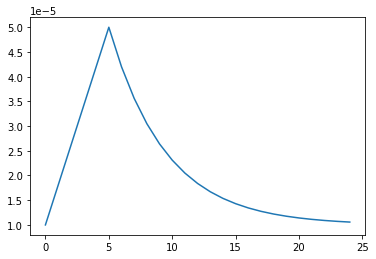

In [ ]:
LR_START = 0.00001
LR_MAX = 0.00005
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)

In [ ]:
tf.keras.utils.plot_model(model ,show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### Callbacks 지정 및 학습시작

In [ ]:
def get_callbacks(model_name):
    callbacks = []
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'model.{model_name}.h5',
        verbose=1,
        save_best_only=True)
    
    erly = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # 3번 허용. 1~2번은 너무 overfitting 가능성..
    callbacks.append(checkpoint)
    callbacks.append(erly)
    callbacks.append(lr_callback)
    return callbacks

#### 문제 : GPU Colab으로 Run
 - 용량 문제로 colab은 data_load에서 애를 먹는다(dataset:약11~12만장/43GB).
 - local에 좋은 GPU가 있었다면..
 - 근데 Tesla GPU를 써도 학습 속도는 비슷하다?

In [ ]:
callbacks = get_callbacks('CustomDenseNet')
history = model.fit(train_gen,
                   steps_per_epoch = 150, # 너무느리다.. 50이나 100으로 조정
                   validation_data = test_gen,
                   validation_steps = 70,
                   epochs = 20,
                   callbacks = callbacks)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 0.8263 - auc: 0.5187 - precision: 0.0792 - recall: 0.5479 - accuracy: 0.0000e+00 
Epoch 00001: val_loss improved from inf to 1.23483, saving model to model.CustomDenseNet.h5
150/150 [==============================] - 2580s 17s/step - loss: 0.8263 - auc: 0.5187 - precision: 0.0792 - recall: 0.5479 - accuracy: 0.0000e+00 - val_loss: 1.2348 - val_auc: 0.0910 - val_precision: 0.0036 - val_recall: 0.0317 - val_accuracy: 0.0000e+00

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 0.3231 - auc: 0.9866 - precision: 0.5147 - recall: 0.9765 - accuracy: 0.0000e+00 
Epoch 00002: val_loss improved from 1.23483 to 0.62390, saving model to model.CustomDenseNet.h5
150/150 [==============================] - 2574s 17s/step - loss: 0.3231 - auc: 0.9866 - precisio

### 마무리 / 확인

In [ ]:
y_pred = model.predict(test_x)

In [ ]:
for label, p_count, t_count in zip(labels,
                                     100 * np.mean(y_pred, 0),
                                     100 * np.mean(test_Y, 0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (label, t_count, p_count))

In [ ]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))

for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [ ]:
print('ROC auc score: {:.3f}'.format(roc_auc_score(test_Y.astype(int), y_pred)))